**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

from datetime import datetime
from os.path import exists

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TRAIN_PREPEARED_PATH = 'prepeared_train.csv'
TEST_PREPEARED_PATH = 'prepeared_test.csv'
HEALTHCARE_FILLER_MODEL_PATH = 'model/healthcare_filler.pkl'
FINAL_MODEL_PATH = 'model/final_model.pkl'
SCALER_PATH = 'model/scaler.pkl'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Уменьшение объёма занимаемой памяти

In [12]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [13]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>

**Целевая переменная**

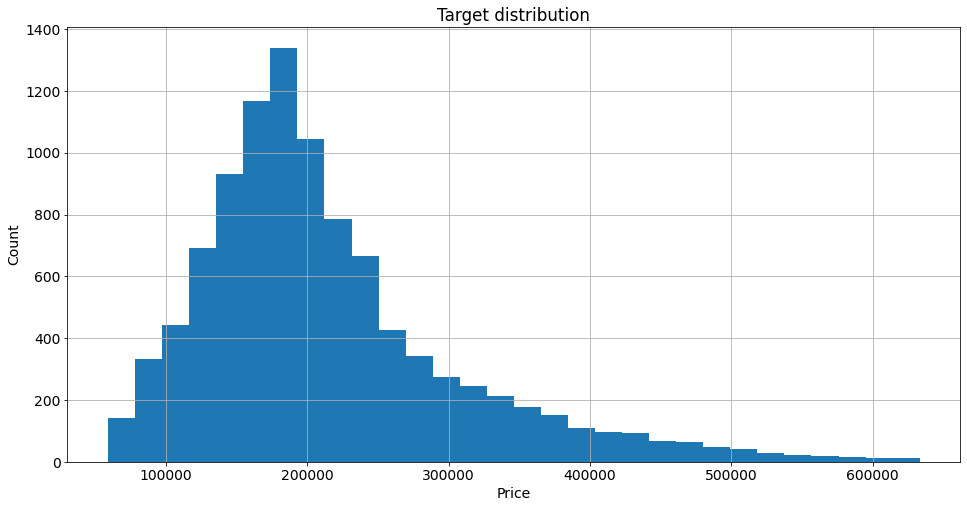

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**Номинативные переменные**

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId']

In [17]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
117      1
196      1
209      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>

**Rooms**

In [21]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Посмотрим на площадь и стоимость квартир, где больше 5 комнат

In [22]:
train_df.loc[train_df['Rooms'] > 5, ['Rooms', 'Square', 'Price']]

,Rooms,Square,Price
2004,10.0,59.056976,317265.312500
2728,10.0,60.871265,172329.265625
6088,19.0,42.006046,78364.617188
8794,6.0,59.414333,229661.968750


Добавим вспомогательное поле с метками выброса

In [23]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

In [24]:
train_df[train_df['Square'].isna()].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier


Заменим на медиану

In [25]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [26]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square**

In [27]:
train_df.loc[(train_df['Square'] > 150) & (train_df['Rooms'] >= 2) & (train_df['Rooms'] <= 3), 'Square'] = \
np.quantile(train_df.loc[(train_df['Rooms'] >= 2) & (train_df['Rooms'] <= 3), 'Square'], 0.75)

In [28]:
train_df.loc[(train_df['Square'] > 250) & (train_df['Rooms'] >= 4) & (train_df['Rooms'] <= 5), 'Square'] = \
np.quantile(train_df.loc[(train_df['Rooms'] >= 4) & (train_df['Rooms'] <= 5), 'Square'], 0.75)

In [29]:
train_df.loc[(train_df['Square'] > 60) & (train_df['Rooms'] == 1), 'Rooms'] = \
train_df.loc[(train_df['Square'] > 60), 'Rooms'].median()

Есть объекты, где указанная жилая площадь больше общей площади квартиры.

In [30]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (~train_df['LifeSquare'].isna()), ['Square', 'LifeSquare', 'Rooms']]

,Square,LifeSquare,Rooms
33,73.314972,74.131264,2.0
64,87.200623,87.730225,3.0
77,38.467278,39.624493,1.0
100,79.937668,82.931595,2.0
111,28.438793,32.514023,1.0
...,...,...,...
9960,96.056786,98.152802,3.0
9962,42.029175,44.682167,1.0
9979,40.043236,41.984322,1.0
9987,62.690056,64.602936,2.0


Заменим в них жилую площадь на средние значения по количеству комнат.

In [31]:
square_medians = train_df.loc[(train_df['LifeSquare'] >= train_df['Square']) & \
             (~train_df['LifeSquare'].isna())].groupby('Rooms').median()[['Square','LifeSquare']]\
            .rename(columns={'LifeSquare': 'Square', 'Square': 'LifeSquare'})

In [32]:
for rooms in range(1, 6):
    train_df.loc[(train_df['LifeSquare'] >= train_df['Square']) & (~train_df['LifeSquare'].isna()) & (train_df['Rooms'] == rooms)\
                 , 'LifeSquare'], train_df.loc[(train_df['LifeSquare'] >= train_df['Square']) & \
                 (~train_df['LifeSquare'].isna()) & (train_df['Rooms'] == rooms), 'Square'] \
    = square_medians.loc[rooms, 'LifeSquare'], square_medians.loc[rooms, 'Square']

In [33]:
train_df.loc[(train_df['LifeSquare'] >= train_df['Square']), ['LifeSquare', 'Square']]

,LifeSquare,Square


**KitchenSquare** 

In [34]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [35]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [36]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [37]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [38]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [39]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

Есть ли среди них значения, когда этажность дома меньше этажа квартиры?

In [40]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Пометим такие значения

In [41]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

Заменим нулевые этажности дома медианами (не может же у дома быть 0 этажей).

In [42]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Соберём индексы, затем заменим значения, превосходящие этажность, случайным расположением в пределах этажности.

In [43]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [44]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [45]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [46]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

Немного читерства.

In [47]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011

А по такому принципу будем поступать в дальнейшем.

In [48]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

**Обработка не числовых признаков**

**Dummies**

In [49]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [50]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']].head()

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


**DistrictSize, IsDistrictLarge**

In [51]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [52]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,1,305018.875000,0,0,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.546875,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.718750,0,0,652
3,2352,1,1.0,40.409908,NaN,3.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,1,168106.000000,0,0,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,1,343995.093750,0,0,89


In [53]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [54]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

### 3. Обработка пропусков  <a class='anchor' id='nan'>

Для начала посчитаем пропуски.

In [55]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
DistrictSize             0
IsDistrictLarge          0
dtype: int64

Жилая площадь напрямую зависит от общей площади и площади кухни.

In [56]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,3.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,3.0
9,79.867477,75.085129,3.0


**LifeSquare**

Стандартно, пометим поля с пропусками, затем заполним пропущенные значения разницей общей площади и площади кухни, уменьшенной на предполагаемую площадь прихожей и санузла.

In [57]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 8

**Healthcare_1**

Попробуем заполнить через обучение

In [58]:
features_healthcare = train_df.drop(['Healthcare_1', 'Id', 'DistrictSize', 'IsDistrictLarge', 
                                     'Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1).columns.to_list()
features_healthcare

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan']

In [59]:
X_healthcare = train_df.loc[~train_df['Healthcare_1'].isna(), features_healthcare]
X_test_healthcare = train_df.loc[train_df['Healthcare_1'].isna(), features_healthcare]
y_healthcare = train_df.loc[~train_df['Healthcare_1'].isna(), 'Healthcare_1']

In [60]:
X_train_healthcare, X_validate_healthcare, y_train_healthcare, y_validate_healthcare = \
train_test_split(X_healthcare, y_healthcare, test_size=0.33, random_state=23)

In [61]:
# rf_healthcare = RandomForestRegressor(
#     n_estimators=100,
#     criterion='mse',
#     max_depth=7,
#     min_samples_leaf=13,
# )
# rf_healthcare.fit(X_train_healthcare, y_train_healthcare)

In [62]:
with open(HEALTHCARE_FILLER_MODEL_PATH, 'rb') as file:
    rf_healthcare = pickle.load(file)

In [63]:
y_pred_train_healthcare = rf_healthcare.predict(X_train_healthcare)
y_pred_healthcare = rf_healthcare.predict(X_validate_healthcare)
r2(y_train_healthcare, y_pred_train_healthcare), r2(y_validate_healthcare, y_pred_healthcare)

(0.8981561139838128, 0.8958347809345042)

In [64]:
# with open(HEALTHCARE_FILLER_MODEL_PATH, 'wb') as file:
#     pickle.dump(rf_healthcare, file)

In [65]:
# with open(HEALTHCARE_FILLER_MODEL_PATH, 'rb') as file:
#     my_model = pickle.load(file)
    
# my_model

In [66]:
y_pred_test = rf_healthcare.predict(X_test_healthcare)
y_pred_test.shape, X_test_healthcare.shape

((4798,), (4798, 17))

In [67]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = y_pred_test

In [68]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [69]:
train_df.isna().sum().sum()

0

### 4. Построение новых признаков  <a class='anchor' id='feature'>

In [70]:
def floor_to_cat(X):
    bins = [0, 2, 4, 9, 15, 24, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):
    bins = [0, 1950, 1970, 1990, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [71]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,LifeSquare_nan,year_cat,floor_cat
0,11809,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,...,0,1,305018.875000,0,0,851,1,1,5,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,1,177734.546875,0,0,78,0,0,1,2
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,1,282078.718750,0,0,652,1,0,2,0
3,2352,1,1.0,40.409908,29.409908,3.0,10,22.0,1977,0.007122,...,1,1,168106.000000,0,0,652,1,1,2,3
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,6,1,343995.093750,0,0,89,0,0,2,4


**MedPriceByDistrict**

Предположим, что стоимость зависит от района

In [72]:
med_price_by_district = train_df.groupby(['DistrictId', 'floor_cat'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,floor_cat,MedPriceByDistrict
0,0,0,156228.375000
1,0,1,175233.656250
2,0,2,162322.781250
3,0,3,197004.375000
4,0,4,256691.921875


In [73]:
med_price_by_district.describe()

,floor_cat,MedPriceByDistrict
count,835.000000,835.000000
mean,1.922156,251292.515625
std,1.388519,88054.101562
min,0.000000,76470.718750
25%,1.000000,189081.484375
50%,2.000000,227219.625000
75%,3.000000,295459.484375
max,5.000000,633233.437500


In [74]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,LifeSquare_nan,year_cat,floor_cat,MedPriceByDistrict
0,11809,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,...,1,305018.875000,0,0,851,1,1,5,1,143111.593750
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,177734.546875,0,0,78,0,0,1,2,187359.937500
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,282078.718750,0,0,652,1,0,2,0,171095.968750
3,2352,1,1.0,40.409908,29.409908,3.0,10,22.0,1977,0.007122,...,1,168106.000000,0,0,652,1,1,2,3,189137.093750
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,343995.093750,0,0,89,0,0,2,4,205688.953125


**MedPriceByYear**

Стоимость также зависит от года постройки

In [75]:
med_price_by_year = train_df.groupby(['year_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
med_price_by_year.head()

,year_cat,Rooms,MedPriceByYear
0,0,1.0,219071.265625
1,0,2.0,309988.250000
2,0,3.0,380100.281250
3,0,4.0,439266.406250
4,0,5.0,479525.156250


In [76]:
med_price_by_year.describe()

,year_cat,Rooms,MedPriceByYear
count,30.000000,30.00000,30.000000
mean,2.500000,3.00000,307915.531250
std,1.737021,1.43839,115336.312500
min,0.000000,1.00000,135133.125000
25%,1.000000,2.00000,202803.144531
50%,2.500000,3.00000,299836.093750
75%,4.000000,4.00000,393623.929688
max,5.000000,5.00000,521724.250000


In [77]:
train_df = train_df.merge(med_price_by_year, on=['year_cat', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,LifeSquare_nan,year_cat,floor_cat,MedPriceByDistrict,MedPriceByYear
0,11809,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,...,305018.875000,0,0,851,1,1,5,1,143111.593750,230923.953125
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,177734.546875,0,0,78,0,0,1,2,187359.937500,158839.312500
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,282078.718750,0,0,652,1,0,2,0,171095.968750,247249.093750
3,2352,1,1.0,40.409908,29.409908,3.0,10,22.0,1977,0.007122,...,168106.000000,0,0,652,1,1,2,3,189137.093750,147612.531250
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,343995.093750,0,0,89,0,0,2,4,205688.953125,194873.906250


**MedPriceBySocial**

Зависимость стоимости от наличия различных социальных объектов

In [78]:
med_price_by_social = train_df.groupby(['Social_3', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial'})
med_price_by_social.head()

,Social_3,Shops_1,MedPriceBySocial
0,0,0,145822.093750
1,0,1,175679.968750
2,0,2,174465.562500
3,0,3,253080.421875
4,0,4,247896.687500


In [79]:
train_df = train_df.merge(med_price_by_social, on=['Social_3', 'Shops_1'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,LifeSquare_nan,year_cat,floor_cat,MedPriceByDistrict,MedPriceByYear,MedPriceBySocial
0,11809,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,...,0,0,851,1,1,5,1,143111.593750,230923.953125,145822.093750
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,78,0,0,1,2,187359.937500,158839.312500,170905.765625
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,652,1,0,2,0,171095.968750,247249.093750,175679.968750
3,2352,1,1.0,40.409908,29.409908,3.0,10,22.0,1977,0.007122,...,0,0,652,1,1,2,3,189137.093750,147612.531250,175679.968750
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,89,0,0,2,4,205688.953125,194873.906250,203153.531250


In [80]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_year = None
        self.med_price_by_social = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding       
        df = X.copy()
        
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
         ## District, floor
        
            self.med_price_by_district = df.groupby(['DistrictId', 'floor_cat'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## year, rooms
        
            self.med_price_by_year = df.groupby(['year_cat', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByYear'})
            self.med_price_by_year_median = self.med_price_by_year['MedPriceByYear'].median()
            
        ## social, shops
        
            self.med_price_by_social = df.groupby(['Social_3', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                                rename(columns={'Price':'MedPriceBySocial'})
            self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_year is not None:
            X = X.merge(self.med_price_by_year, on=['year_cat', 'Rooms'], how='left')
            X.fillna(self.med_price_by_year_median, inplace=True)
            
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Social_3', 'Shops_1'], how='left')
            X.fillna(self.med_price_by_social_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 2, 4, 9, 15, 24, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)    
        X['floor_cat'].fillna(-1, inplace=True)
        return X


    def year_to_cat(self, X):
        bins = [0, 1950, 1970, 1990, 2000, 2010, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

In [81]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.square_quantile = None
        self.square_medians_by_rooms = None
        self.gt_60_sq_rooms_median = None
        if exists(HEALTHCARE_FILLER_MODEL_PATH):
            with open(HEALTHCARE_FILLER_MODEL_PATH, 'rb') as file:
                self.hc_filler = pickle.load(file)
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.gt_60_sq_rooms_median = X.loc[(X['Square'] > 60), 'Rooms'].median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.square_2_3_quantile = X.loc[(X['Square'] > 150) & (X['Rooms'] >= 2) & (X['Rooms'] <= 3), 'Square'].quantile(.75)
        self.square_4_5_quantile = X.loc[(X['Square'] > 250) & (X['Rooms'] >= 4) & (X['Rooms'] <= 5), 'Square'].quantile(.75)
        self.square_medians_by_rooms = X.loc[(X['LifeSquare'] >= X['Square']) \
                                             & (~X['LifeSquare'].isna())].groupby('Rooms').median()[['Square','LifeSquare']]
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[(X['Square'] > 150) & (X['Rooms'] >= 2) & (X['Rooms'] <= 3), 'Square'] = self.square_2_3_quantile
        X.loc[(X['Square'] > 250) & (X['Rooms'] >= 4) & (X['Rooms'] <= 5), 'Square'] = self.square_4_5_quantile
        X.loc[(X['Square'] > 60) & (X['Rooms'] == 1), 'Rooms'] = self.gt_60_sq_rooms_median
        
        if self.square_medians_by_rooms is not None and self.square_medians_by_rooms.shape[0] > 0:
            for rooms in range(1, len(self.square_medians_by_rooms)):
                X.loc[(X['LifeSquare'] >= X['Square']) & (~X['LifeSquare'].isna()) & (X['Rooms'] == rooms), 'LifeSquare'], \
                X.loc[(X['LifeSquare'] >= X['Square']) & (~X['LifeSquare'].isna()) & (X['Rooms'] == rooms), 'Square'] \
                = self.square_medians_by_rooms.loc[rooms, 'Square'], self.square_medians_by_rooms.loc[rooms, 'LifeSquare']

        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 8
        
        # Healthcare_1
        if self.hc_filler is not None:
            features_healthcare = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                                   'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1',
                                   'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Rooms_outlier', 
                                   'HouseFloor_outlier', 'LifeSquare_nan']
            x_healthcare_na = X.loc[X['Healthcare_1'].isna(), features_healthcare]
            X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.hc_filler.predict(x_healthcare_na)
            
        X.fillna(self.medians, inplace=True)
        
        return X

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [82]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'LifeSquare_nan',
 'year_cat',
 'floor_cat',
 'MedPriceByDistrict',
 'MedPriceByYear',
 'MedPriceBySocial']

In [83]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByYear', 'MedPriceBySocial']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [84]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=23)

In [86]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6764,6277,39,1.0,50.159704,18.644196,11.0,18,16.0,2006,0.428826,B,B,25,5011,8,730.0,0,2,B
389,16396,27,2.0,66.700791,60.243588,1.0,15,19.0,2017,0.017647,B,B,2,469,0,NaN,0,0,B
2095,7423,12,1.0,38.976391,21.445835,8.0,9,14.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B
7976,12218,55,1.0,36.059910,22.614774,9.0,16,16.0,1979,0.012339,B,B,35,5776,1,2078.0,2,4,B
1493,1570,27,3.0,81.631946,NaN,10.0,19,22.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B


In [87]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [88]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [89]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [90]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [91]:
# final_model = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=8,
#                                      min_samples_leaf=17,
#                                      random_state=23,  
#                                      n_estimators=200)
# final_model.fit(X_train, y_train)

In [92]:
with open(FINAL_MODEL_PATH, 'rb') as file:
    final_model = pickle.load(file)

**Оценка модели**

Train R2:	0.928
Test R2:	0.706


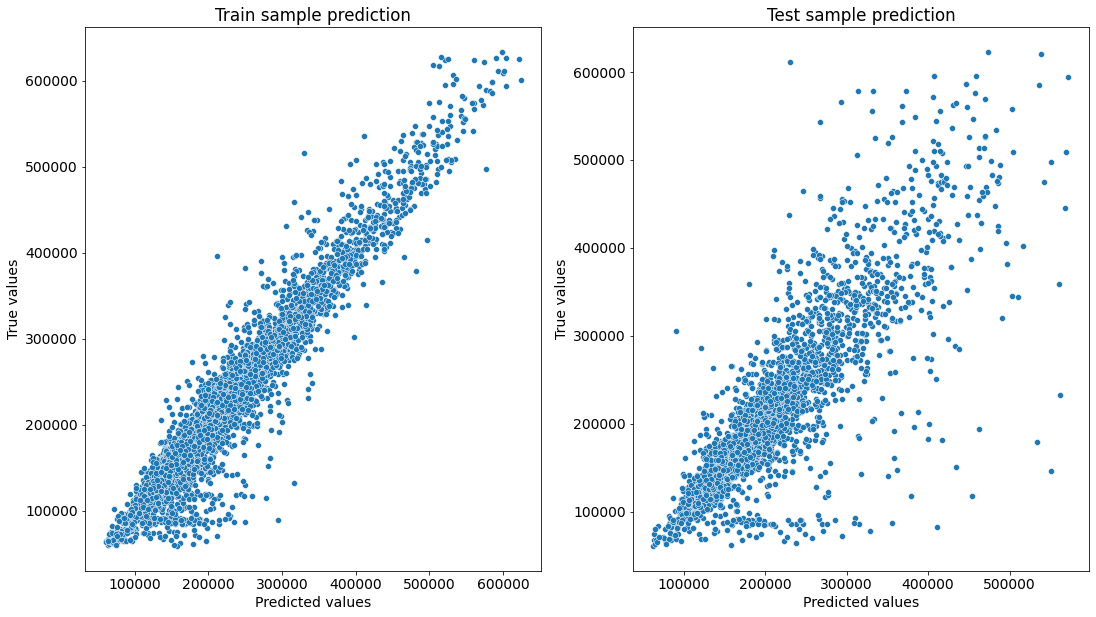

In [93]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [94]:
cv_score = cross_val_score(final_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=23))
cv_score

array([0.72257149, 0.72680397, 0.74826304])

In [95]:
cv_score.mean()

0.7325461665697017

**Важность признаков**

In [96]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
24,MedPriceByDistrict,3.058677e-01
25,MedPriceByYear,2.730777e-01
1,Square,2.185360e-01
2,LifeSquare,2.579049e-02
13,Healthcare_1,2.447042e-02
26,MedPriceBySocial,2.218722e-02
21,DistrictSize,2.208877e-02
6,HouseYear,1.902083e-02
12,Social_3,1.500963e-02
10,Social_1,1.372496e-02


**Сохраняем модельку**

In [97]:
# with open(FINAL_MODEL_PATH, 'wb') as file:
#     pickle.dump(final_model, file)

Проверим, что читается

In [98]:
# with open(FINAL_MODEL_PATH, 'rb') as file:
#     my_model = pickle.load(file)
    
# my_model

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [99]:
test_df.shape

(5000, 27)

In [100]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByYear,MedPriceBySocial
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,74.0,0,0,233185.240985,158355.649058,177420.591293
1,1.0,42.493907,40.696294,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,163.0,0,1,143407.248516,135133.112300,167544.244106
2,2.0,59.463678,42.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,1,581.0,0,1,131742.536281,194091.992560,177420.591293
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,378.0,0,1,102797.409974,278999.606482,147317.005639
4,1.0,53.837056,42.837056,3.0,8,17.0,1977,0.309479,1,1,...,0,0,0,1,75.0,0,0,185976.351147,147308.581394,220773.355688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,3,5.0,1962,0.069660,1,1,...,0,1,0,0,63.0,0,0,175524.568714,197957.137243,180611.298860
4996,3.0,93.698122,81.728604,10.0,21,27.0,2018,0.060753,1,1,...,0,0,0,0,24.0,0,0,372468.397635,228452.614044,269128.319210
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,0,0,0,0,62.0,0,0,173695.247001,158355.649058,181362.622170
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,0,0,0,35.0,0,0,224282.203029,158355.649058,215649.375679


In [101]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [102]:
predictions = final_model.predict(test_df)
predictions

array([173176.90628198, 117705.57374701, 131453.64201179, ...,
       141098.95340044, 189470.05959234, 264061.29249445])

In [103]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,173176.906282
1,5925,117705.573747
2,960,131453.642012
3,3848,121300.598052
4,746,206663.989642


In [104]:
submit.to_csv('gb_submit.csv', index=False)